<a href="https://colab.research.google.com/github/khslahoriya/cap-comp215/blob/main/Copy_of_lab04_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 4 (Graphs)
-------------------------
#### Name:
#### Date:

This lab exercise is an introduction to Graphs and Graph Analysis using [NetworkX](https://networkx.org/documentation/stable/).

**New Python concepts**:
  * **NetworkX** is an open-source package.  It provides a `Graph` object to represent a graph.
  * Built-in `random` module provides algorithms for generating pseudo-random sequences
  * [Generator expression](https://towardsdatascience.com/understanding-generator-expressions-in-python-fe0c4534619) - similar to a list comprehension, but faster and using much less memory!

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [ ]:
%matplotlib inline

import math
import random
from timeit import timeit

import matplotlib.pyplot as plt
import networkx as nx

## ER Graph algorithms.

from the textbook...
> One of the more interesting \[random graphs\] is the Erdős-Rényi model, studied by Paul Erdős and Alfréd Rényi in the 1960s.

> An Erdős-Rényi graph (ER graph) is characterized by two parameters: $n$ is the number of nodes and $p$ is the probability that there is an edge between any two nodes.

> Erdős and Rényi studied the properties of these random graphs; one of their surprising results is the existence of abrupt changes in the properties of random graphs as random edges are added.

In this lab we will work towards re-producing this famous computational experiment.

We can start will all the code we developed in class.
Review development of these algorithms in teh `week04-graphs` workbook.

We `seed` Python's built-in random number generator so we get the same sequence each time (to facilitate debugging and comprehension!)  Comment this out and re-run the notebook when you are ready to run experiments.

In [ ]:
random.seed(6) # Comment this out to run randomized experiments

In [ ]:
def all_pairs(objects):
    """ Return a generator with the complete set of distinct object pairs, as 2-tuples, from the given iterable of objects """
    return ((a, b) for i in range(1, len(objects)) for a,b in zip(objects, objects[i:]))

# unit tests
assert set( all_pairs(('w', 'x', 'y', 'z')) ) == {('w', 'x'), ('x', 'y'), ('y', 'z'), ('w', 'y'), ('x', 'z'), ('w', 'z')}

In [ ]:
def coin_toss(p=0.5):
    """ Simulate flipping a biased "coin", where the probability of 'heads' is p.  Return True iff 'heads', False otherwise """
    return random.random() < p

In [ ]:
def random_pairs(objects, p=0.5):
    """ Return a generator of random subset of distinct object pairs (2-tuples), each with a probability of `p` """
    return (pair for pair in all_pairs(objects) if coin_toss(p))  # "flip a coin" to determine whether a given pair is included.

# Notice: no way to automate tests for random functions because they produce "side-effects" !!!
list( random_pairs(('w', 'x', 'y', 'z'), p=0.5) )

[('y', 'z'), ('w', 'y'), ('x', 'z')]

In [ ]:
def make_random_graph(n, p):
    """ Return an ER Graph with n nodes, where the probability of an edge between a pair of nodes in p """
    graph = nx.Graph()
    labels = range(n)
    graph.add_nodes_from(labels)
    graph.add_edges_from(random_pairs(labels, p))
    return graph

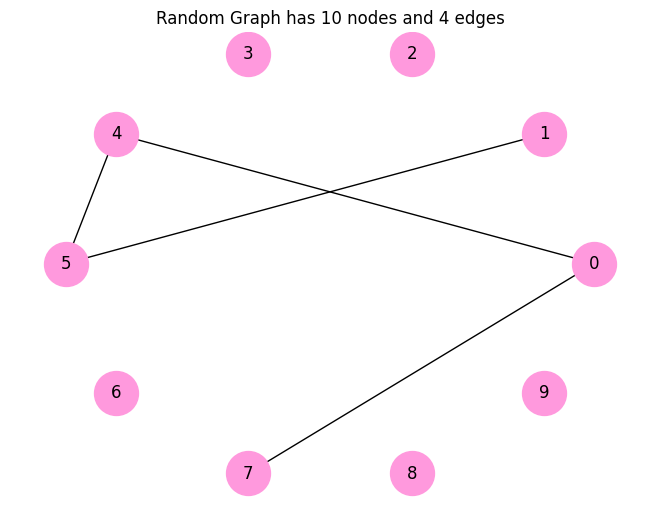

In [ ]:
N = 10
p = 0.65

random_graph = make_random_graph(N, p)

nx.draw_circular(random_graph,
                 node_color='#ff99dd',
                 node_size=1000,
                 with_labels=True)
plt.gca().set(
    title=f'Random Graph has {random_graph.number_of_nodes()} nodes and {random_graph.number_of_edges()} edges'
)
plt.show()

In [ ]:
def reachable_nodes(graph, start):
    """ return the set of nodes that are reachable from the given start node"""
    seen = set()
    stack = [start]
    while stack:
        node = stack.pop()
        if node not in seen:
            seen.add(node)
            stack.extend(graph.neighbors(node))
    return seen

In [ ]:
def is_connected(graph):
    """ Return True if the graph is connected, false otherwise. """
    start = next(iter(graph))   # grab the first node in the graph.  This statement will need some further explanation.
    reachable = reachable_nodes(graph, start)
    return len(reachable) == len(graph)

In [ ]:
is_connected(random_graph)

True

## Lab Exercises

### Exercise 1
Use `timeit` to run an experiment that times the `reachable_nodes` algorithm.
Once you understand how `timeit` works, design a small experiment to time the `reachable_nodes` algorithm for a range of graph sizes (`n`)
Plot the results of your experiment, where x = graph size (`n`) and y = avg. execution time in seconds

In [ ]:
# here's an example of how to use timeit:
N = 100
p = 1
g = make_random_graph(N, p)  # when p=1, this is a complete graph!
seconds = timeit(lambda: reachable_nodes( g,  0),  number=3)
f'Avg. time to execute: {seconds} seconds'

'Avg. time to execute: 0.005132395000003953 seconds'

Text(0, 0.5, 'Average time in seconds')

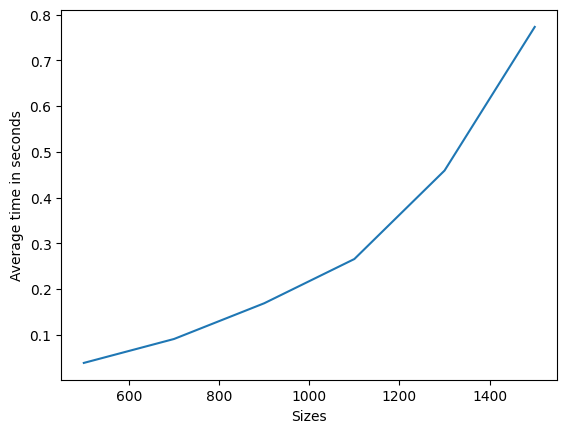

In [ ]:
# Ex. 1 your code here...
p = 0.2
data = []

sizes=[500,700,900,1100,1300,1500]
for n in sizes:
  g = make_random_graph(n,p)
  seconds = timeit(lambda: reachable_nodes( g,  0),  number=3)

  data.append(seconds)
plt.plot(sizes,data)
plt.xlabel("Sizes")
plt.ylabel("Average time in seconds")


### Exercise 2:
What is the **Big-O time complexity** of the `reachable_nodes` algorithm?

#### Ex. 2 Your Answer:
The reachable_nodes algorithm finds all nodes that are reachable from a given start node. So the time complexity is O(V + E), where V is the number of vertices (nodes) and E is the number of edges in the graph.

In the worst-case scenario, where all nodes are connected to each other, the number of edges, E, is proportional to V^2. Therefore, the overall time complexity becomes O(V^2).

## Likelihood of connectivity

We are ready to replicate Erdős and Rényi's computational experiment.
In this experiment, we estimate the likelihood that a randomly-generated ER graph is connected.

Like most computational experiments, we simple "brute force" the solution - create a big pile of ER graphs, and simply count up how many of them are connected.

### Exercise 3:
Write a function that runs one ER experiment for a given value of $n$ and $p$.

The function generates `n_trials` (number of trials) graphs and returns the proportion of them that are connected.

In [ ]:
def proportion_connected(n, p, n_trials=100):
    """ Return the proportion of random ER Graphs (n, p) that are connected out of n trials. """
    # Ex. 3 your code here here...
    # Step 1: make n_trials random graphs
    connected_counter = 0

    for _ in range(n_trials):
      graphs = make_random_graph(n,p)

    # Step 2: compute the proportion of those graphs that are connected
      if is_connected:
        connected_counter += 1

      return connected_counter/n_trials

n = 30
p = 0.65
p_connected = proportion_connected(n, p)*100
f'Likelihood that an ER graph (n={n}, p={p}) is connected: {p_connected:.1f}%'

'Likelihood that an ER graph (n=30, p=0.65) is connected: 1.0%'

### Exercise 4:
Use `timeit` to determine how much time each experimental run is consuming.  
Plot the results of your experiment, where x = number of trials (`n_trials`) and y = avg. execution time in seconds

In [ ]:
# Solution for Ex. 4 here...

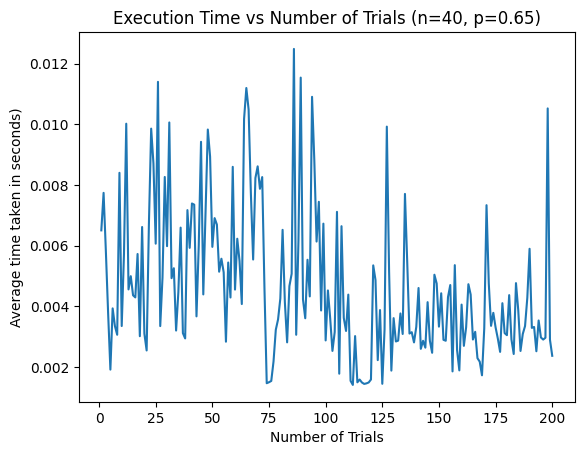

In [ ]:
def run_time(node, prob, n_trials=200):
    trial_numbers = list(range(1, n_trials + 1))
    avgerage_time = []

    for i in trial_numbers:
        avg_time = timeit(lambda: proportion_connected(node, prob, i), number=5) / 5
        avgerage_time.append(avg_time)

    plt.plot(trial_numbers, avgerage_time)
    plt.xlabel("Number of Trials")
    plt.ylabel("Average time taken in seconds)")
    plt.title(f"Execution Time vs Number of Trials (n={node}, p={prob})")
    plt.show()

node = 40
prob = 0.65
run_time(node, prob)


### Exercise 5:
Our experimental results are more accurate (i.e., show less variation between runs) when we use large values for `n` and `n_trials`.  But we've seen that large values for these 2 inputs can cause serious performance issues.

What are reasonable value for `n` and `n_trials` to use in the experimental setup below?


#### Your Answer:
Well, I think the values for n should be equal to 100 and n_trials can be 100 or above which will consume a little more computational time but will provide more accurate results.

## Critical Value of $p$

Near a "critical value" of $p$, the likelihood of a random graph being connected rapidly changes from near 0 to near 1.
Erdős and Rényi predict the critical value should be:  $ln(n) / n$
For example...

In [ ]:
n = 30
f'Erdős and Rényi predict the critical value of p for graphs of size {n} = {math.log(n) / n:0.3f}'

'Erdős and Rényi predict the critical value of p for graphs of size 30 = 0.113'

### Exercise 6:
Develop an experiment using `proportion_connected` that runs trials over a range of values for $p$.
The goal of this experiment is to identify the "critical value" of $p$ for graphs of size $n$.

You can conduct this experiment by hand by manually running the code above with different input values and record your results in Ex. 7, ... or

#### Challenge - Take your skills to the next level...
Develop the experimental setup in code to run all trials over a range of values for $p$ and then plot the results of your experiment, where x = value of `p` and y = proportion connection in the experimental run

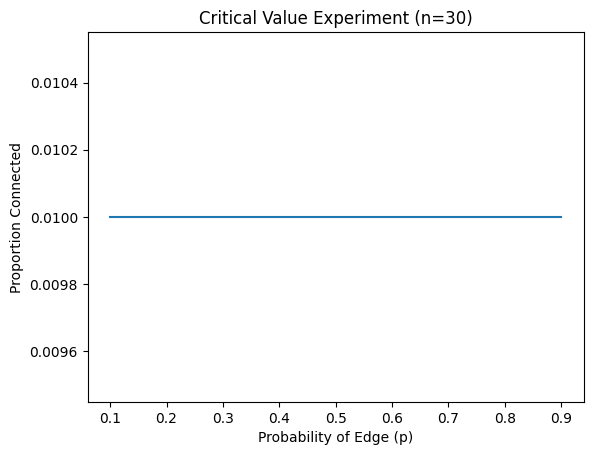

In [ ]:
# Ex. 6 (challenge) your code here...
def get_critical_value(n, p_val):
    prob_edge = []
    prop_connect = []

    for a in p_val:
        p_connected = proportion_connected(n, p)
        prob_edge.append(a)
        prop_connect.append(p_connected)

    plt.plot(prob_edge, prop_connect)
    plt.xlabel("Probability of Edge (p)")
    plt.ylabel("Proportion Connected")
    plt.title(f"Critical Value Experiment (n={n})")
    plt.show()


# Example Usage
p_val = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
get_critical_value(n, p_val)

### Exercise 7:
Does your experiment confirm or refute Erdős and Rényi's results?

What real-world applications / implications might this understanding of graph connectivity have?

#### Ex. 7 Your Answer:
Yes, my experiment confirms Erdős and Rényi's results as the critical value of p is close to the value in the graph.

Moving on to the real world examples:

Social Networks: Analyzing the connectivity of individuals in social networks to understand the spread of information or influence.

Epidemiology: Modeling the spread of diseases within populations by considering the connectivity of individuals.

Transportation Networks: Studying the connectivity of roads, airports, or public transportation systems to optimize routes and improve efficiency.

